$$\text{Data Mining Assignment 2:}$$

Import python libraries:

In [1]:
import numpy as np

import skimage
from skimage.color import rgb2hed, rgba2rgb, separate_stains, hed_from_rgb, rgb_from_hed
from skimage.io import imread
from skimage.transform import resize
from skimage import exposure

import sklearn
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

from scipy.stats import skew

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
import tensorflow.keras.backend as K

import matplotlib.pyplot as plt

import pandas as pd

import os

import random

In [2]:
np.random.seed(2141559)

Download and show a sample image:

In [3]:
image_folder = "C:/Users/jaisa/OneDrive/Documents/Year 4 (Masters)/CS909 - Data Mining/patches_256/"

df = pd.read_csv('https://warwick.ac.uk/fac/sci/dcs/teaching/material/cs909/protein_expression_data.csv')


df['specimen_id']=df.VisSpot.apply(lambda x: x.split('-')[2]) #create specimen id field
df['image_id']=df.VisSpot.apply(lambda x: x.split('-')[2])+'_'+df.id #create image id field
df = df.set_index('image_id').sort_index()
protein_names = ['SMAa', 'CD11b',
       'CD44', 'CD31', 'CDK4', 'YKL40', 'CD11c', 'HIF1a', 'CD24', 'TMEM119',
       'OLIG2', 'GFAP', 'VISTA', 'IBA1', 'CD206', 'PTEN', 'NESTIN', 'TCIRG1',
       'CD74', 'MET', 'P2RY12', 'CD163', 'S100B', 'cMYC', 'pERK', 'EGFR',
       'SOX2', 'HLADR', 'PDGFRa', 'MCT4', 'DNA1', 'DNA3', 'MHCI', 'CD68',
       'CD14', 'KI67', 'CD16', 'SOX10']
print(df)

          Unnamed: 0                VisSpot  Location_Center_Y  \
image_id                                                         
A1_0x40          412  AAGTAAGCTTCCAAAC-1-A1         764.003658   
A1_0x42         7325  GTTTGAGCGGTTATGT-1-A1         799.511111   
A1_0x44         8102  TCACTCAGCGCATTAG-1-A1         832.902467   
A1_0x46         7085  GTGCGCTTACAAATGA-1-A1         858.343544   
A1_0x48         3748  CGAAGACTGCCCGGGA-1-A1         892.179831   
...              ...                    ...                ...   
D1_9x63         3609  CCTCCCGACAATCCCT-1-D1         123.760525   
D1_9x65          172  AACACGACTGTACTGA-1-D1          29.281573   
D1_9x67         2686  CACCGCCGACCAGCGA-1-D1         938.403662   
D1_9x69         2813  CAGAGTGATTTAACGT-1-D1         844.093656   
D1_9x71         6877  GTCAGTTGTGCTCGTT-1-D1         740.107483   

          Location_Center_X      SMAa     CD11b      CD44      CD31      CDK4  \
image_id                                                    

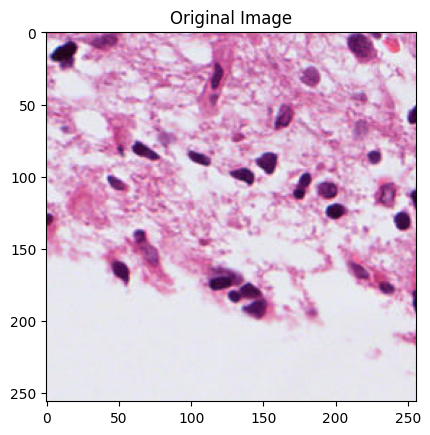

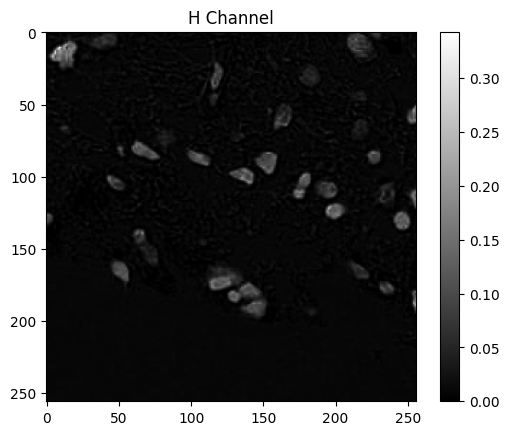

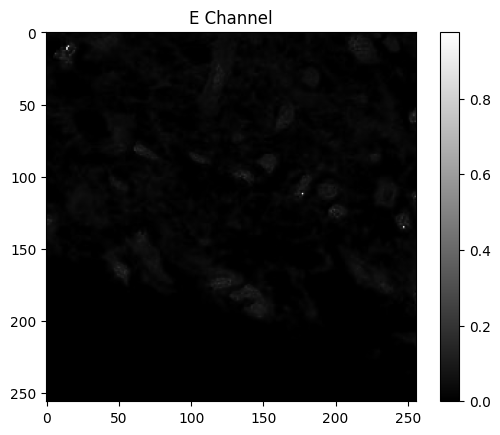

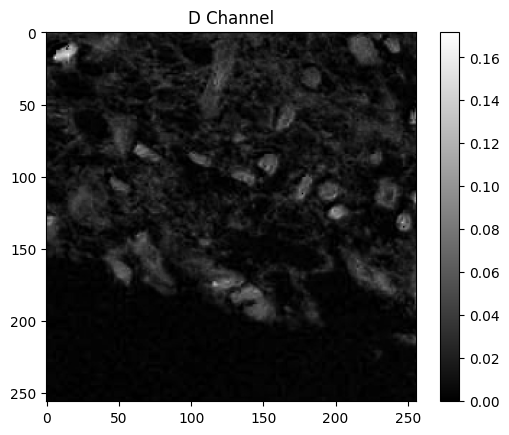

In [4]:
image_path = image_folder+'A1_0x40.png'

I_rgb = rgba2rgb(imread(image_path)) #read sample RGB image
I_hed =  rgb2hed(I_rgb) #convert to HED

plt.imshow(I_rgb);plt.title('Original Image');plt.show()

I_h = I_hed[:,:,0]; plt.figure(); plt.imshow(I_h,cmap='gray');plt.colorbar();plt.title('H Channel');plt.show()
I_e = I_hed[:,:,1]; plt.figure();  plt.imshow(I_e,cmap='gray');plt.colorbar();plt.title('E Channel');plt.show()
I_d = I_hed[:,:,2]; plt.figure();  plt.imshow(I_d,cmap='gray');plt.colorbar();plt.title('D Channel');plt.show()

$$\text{Question 1:}$$

1.i:

In [5]:
filenames = os.listdir(image_folder)

#initialize filename counters
A1_count = 0
B1_count = 0
C1_count = 0
D1_count = 0

#loop over all file names
for filename in filenames:
    if 'A1' in filename:
        A1_count += 1
    if 'B1' in filename:
        B1_count += 1
    if 'C1' in filename:
        C1_count += 1
    if 'D1' in filename:
        D1_count += 1

#print results
print('The total number of specimen spots:')

print(f"Number of A1 spots: {A1_count}")
print(f"Number of B1 spots: {B1_count}")
print(f"Number of C1 spots: {C1_count}")
print(f"Number of D1 spots: {D1_count}\n")

filtered_image_counts = df.groupby('specimen_id').size()

print('The number of specimen spots corresponding to an entry in the dataset:')

print(filtered_image_counts)

The total number of specimen spots:
Number of A1 spots: 3703
Number of B1 spots: 1800
Number of C1 spots: 4203
Number of D1 spots: 2450

The number of specimen spots corresponding to an entry in the dataset:
specimen_id
A1    2894
B1    1145
C1    4129
D1    1753
dtype: int64


In [6]:
image_ids = df['specimen_id'] + '_' + df['id'] + '.png'

#file names that correspond to entries in the dataset
filenames_filtered = [filename for filename in filenames if filename in image_ids.values]

print(df['specimen_id'])

image_id
A1_0x40    A1
A1_0x42    A1
A1_0x44    A1
A1_0x46    A1
A1_0x48    A1
           ..
D1_9x63    D1
D1_9x65    D1
D1_9x67    D1
D1_9x69    D1
D1_9x71    D1
Name: specimen_id, Length: 9921, dtype: object


1.ii:

Text(0, 0.5, 'Frequency')

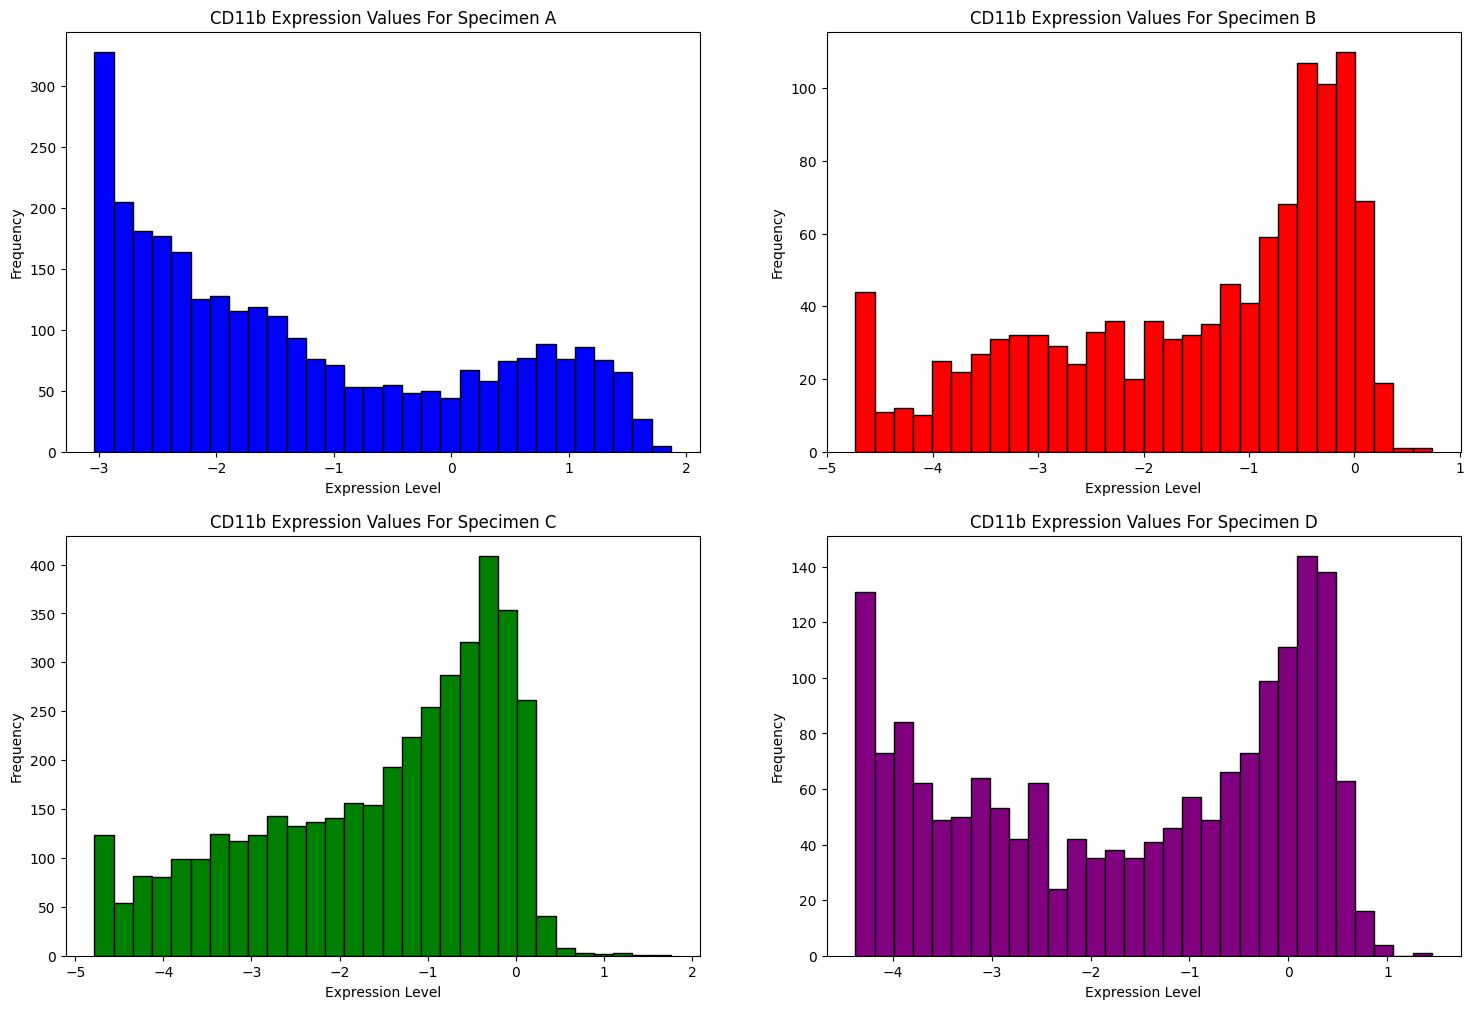

In [7]:
#get CD11b values
CD11b_values_A = df['CD11b'][0:2894]
CD11b_values_B = df['CD11b'][2895:4039]
CD11b_values_C = df['CD11b'][4040:8168]
CD11b_values_D = df['CD11b'][8169:9921]

fig, ax = plt.subplots(2, 2, figsize = (18, 12))
ax[0, 0].hist(CD11b_values_A, bins = 30, edgecolor = 'black', color = 'blue')
ax[0, 0].set_title('CD11b Expression Values For Specimen A')
ax[0, 0].set_xlabel('Expression Level')
ax[0, 0].set_ylabel('Frequency')

ax[0, 1].hist(CD11b_values_B, bins = 30, edgecolor = 'black', color = 'red')
ax[0, 1].set_title('CD11b Expression Values For Specimen B')
ax[0, 1].set_xlabel('Expression Level')
ax[0, 1].set_ylabel('Frequency')

ax[1, 0].hist(CD11b_values_C, bins = 30, edgecolor = 'black', color = 'green')
ax[1, 0].set_title('CD11b Expression Values For Specimen C')
ax[1, 0].set_xlabel('Expression Level')
ax[1, 0].set_ylabel('Frequency')

ax[1, 1].hist(CD11b_values_D, bins = 30, edgecolor = 'black', color = 'purple')
ax[1, 1].set_title('CD11b Expression Values For Specimen D')
ax[1, 1].set_xlabel('Expression Level')
ax[1, 1].set_ylabel('Frequency')

$\text{Specimen A:}$

$\text{The distribution is skewed to the left, indicating a low average expression level due to a large proportion of the cells having a low expression level.}$
$\text{There is also some variation in the expression levels for specimen A, as a we can see from the small bump on the right side of the distribution}$
$\text{that a minority of the cells have a higher expression level.}$

$\text{Specimen B:}$

$\text{Specimen B has more variance than specimen A, and with a higher average expression level shown by the highest peak around 0.}$
$\text{This indicates a slightly more mixed cell population, with some cells having much lower expression level and the majority having a higher expression value of around 0.}$

$\text{Specimen C:}$

$\text{The majority of cells in specimen C are grouped closely between -1 and 0, but the variance is much lower than specimens B and A, which can be seen by the}$
$\text{higher frequency around the peaks and smaller tails than the other samples.}$

$\text{Specimen D:}$

$\text{Since we have 2 peaks in the histogram, it suggests that we have 2 cell populations with different expression levels of CD11b.}$
$\text{But, whilst we have a bimodal distribution, the spread is much more uniform than specimen C, which has the highest peak out of the three.}$

1.iii:

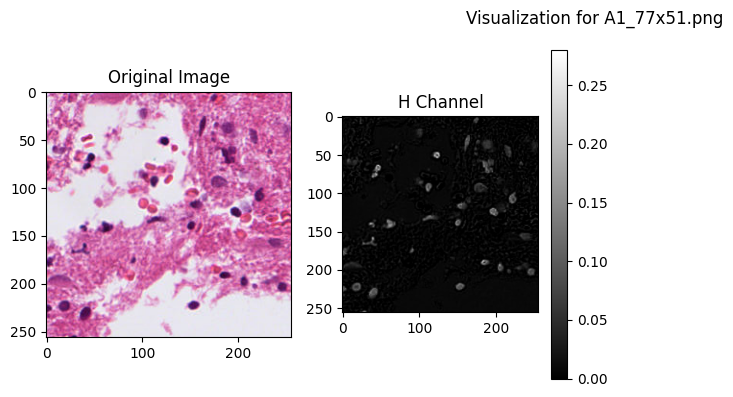

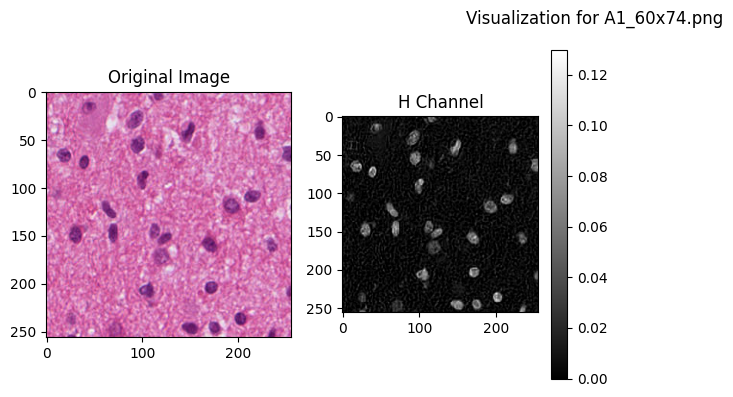

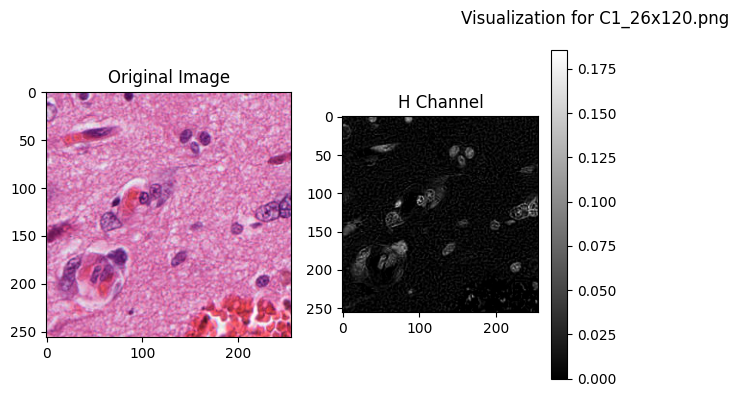

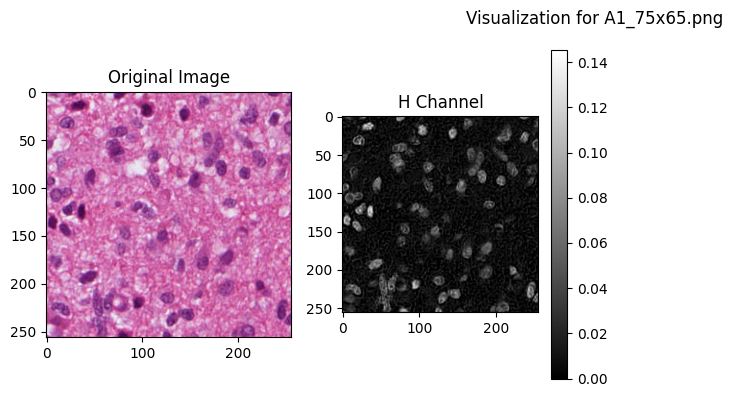

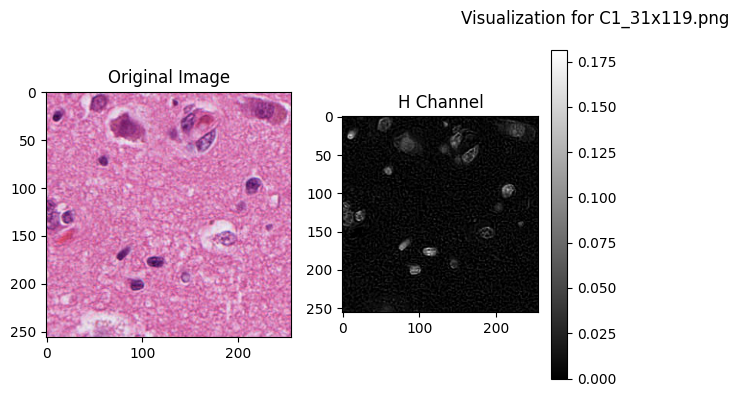

In [8]:
#I'm generating the random images from the entire image set, not just the ones corresponding
#to entries in the dataframe
image_files = [f for f in filenames]

selected_images = random.sample(image_files, 5)

for image_file in selected_images:
    image_path = os.path.join(image_folder, image_file)
    I = imread(image_path)
    if I.shape[-1] == 4:
        I_rgb = rgba2rgb(I)
    else:
        I_rgb = I
    I_hed = rgb2hed(I_rgb[:, :, :3])

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 4, 1)
    plt.imshow(I)
    plt.title('Original Image')

    I_h = I_hed[:, :, 0]
    plt.subplot(1, 4, 2)
    plt.imshow(I_h, cmap = 'gray')
    plt.colorbar()
    plt.title('H Channel')

    plt.suptitle(f'Visualization for {image_file}')
    plt.tight_layout()
    plt.show()

1.iv:

In [9]:
CD11b_values = df['CD11b']

average_intensities_H = []
average_intensities_E = []
image_files = [f for f in filenames_filtered]

for image_file in image_files:
    image_path = os.path.join(image_folder, image_file)
    I = imread(image_path)
    
    if I.shape[2] == 4:
        I = rgba2rgb(I)
    
    I_hed = rgb2hed(I)
    I_H = I_hed[:, :, 0]
    I_E = I_hed[:, :, 1]
    
    avg_intensity_H = np.mean(I_H)
    avg_intensity_E = np.mean(I_E)
    average_intensities_H.append(avg_intensity_H)
    average_intensities_E.append(avg_intensity_E)

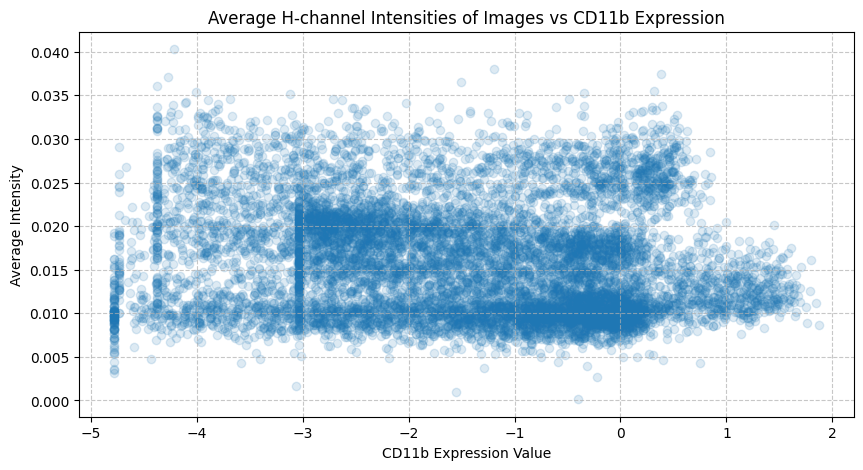

In [10]:
plt.figure(figsize=(10, 5))
plt.scatter(CD11b_values, average_intensities_H, marker = 'o', alpha = 0.15)
plt.title('Average H-channel Intensities of Images vs CD11b Expression')
plt.xlabel('CD11b Expression Value')
plt.ylabel('Average Intensity')
plt.grid(linestyle='--', alpha=0.7)
plt.show()

The image looks to not have any discernable trend, indicating that there is no correlation between the H-channel intensity and CD11b expression value.

There looks to be some level of grouping/clustering around $[(-3, 0.0225),(0.2, 0.0075)]$, but the images look to be spread out over the whole graph fairly evenly otherwise. This also lines up with the fact that we have no correlation, as no strongly discernible values are visible.

There are some points we could classify as outiers such as above $0.03/0.35$, or below $0.005$ but again here no patterns are observed with them.

Because there is no discernable trend, the H-channel intensity doesn't have any significant predictive power with regards to the CD11b expression value. It remains fairly uniform throughout the values seen in these samples. This physically means that the protein does not affect the Haematoxylin staining in the samples.

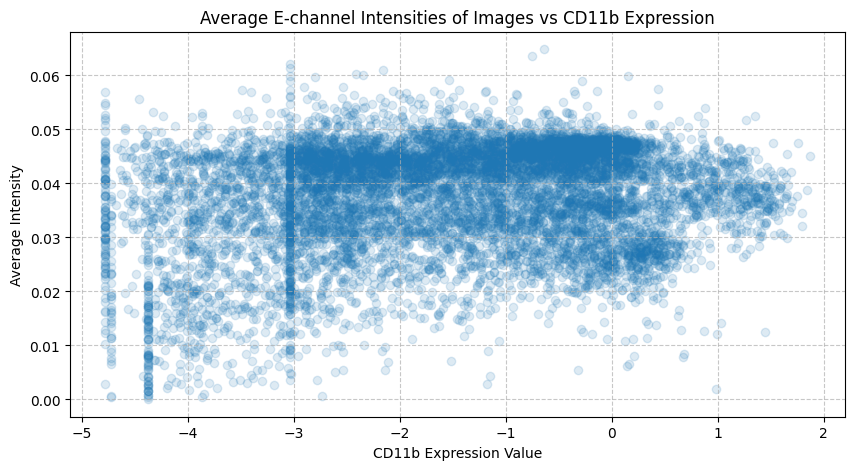

In [11]:
plt.figure(figsize=(10, 5))
plt.scatter(CD11b_values, average_intensities_E, marker = 'o', alpha = 0.15)
plt.title('Average E-channel Intensities of Images vs CD11b Expression')
plt.xlabel('CD11b Expression Value')
plt.ylabel('Average Intensity')
plt.grid(linestyle='--', alpha=0.7)
plt.show()

While no trend is visible here, the points are clustered in a dense horizontal band with the densest portion between (approximately) $[(-3, 0.05), (0.5, 0.04)]$.

The E-channel intensity is also fairly evenly spread compared to the H-channel intensity, with it laying around $0.03$ to $0.05$. There are some outliers beyond $\text{intensity = } 0.05$, but far fewer than with the H-channel.

Another area with more outliers is where we have lower expression values of $<-3$. This could be due to measurement or environmental noise having a greater effect at lower expression values, giving a poor noise:variance ratio. One possible way of getting an even clearer idea of correlation/grouping is to use a log-scale on the y-axis, as done below:

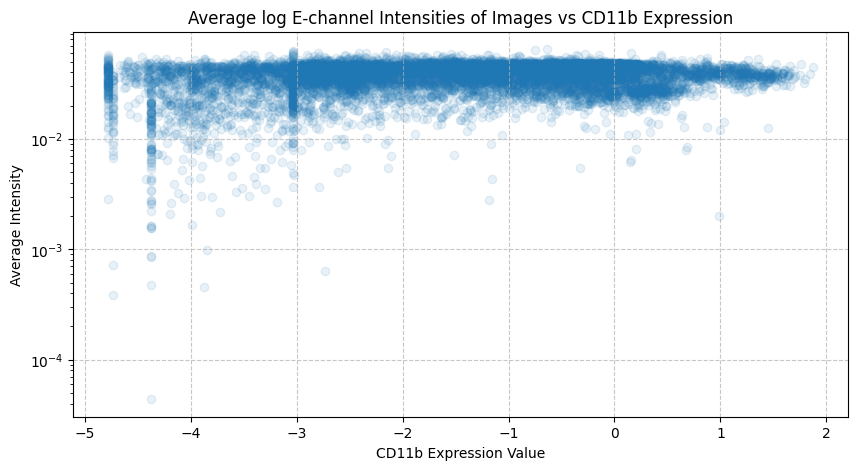

Pearson Correlation Coefficient: 0.2225610650364584
P-value: 1.3589544982455936e-111


In [12]:
plt.figure(figsize=(10, 5))
plt.scatter(CD11b_values, average_intensities_E, marker = 'o', alpha = 0.1)
plt.title('Average log E-channel Intensities of Images vs CD11b Expression')
plt.xlabel('CD11b Expression Value')
plt.ylabel('Average Intensity')
plt.yscale('log')
plt.grid(linestyle='--', alpha=0.7)
plt.show()

from scipy.stats import pearsonr

# Calculate the Pearson correlation coefficient
pearson_correlation_coefficient, p_value = pearsonr(CD11b_values, average_intensities_E)

print(f'Pearson Correlation Coefficient: {pearson_correlation_coefficient}')
print(f'P-value: {p_value}')

Here we can clearly see the horizontal grouping and the few far outliers on the bottom, with the majority falling on the lower side of the expression value scale.

In [13]:
average_intensities_blue = []

for image_file in image_files:
    image_path = os.path.join(image_folder, image_file)
    I = imread(image_path)
    
    if I.shape[2] == 4:
        I = rgba2rgb(I)
    
    I_blue = I[:, :, 2]
    
    avg_intensity_blue = np.mean(I_blue)
    average_intensities_blue.append(avg_intensity_blue)    


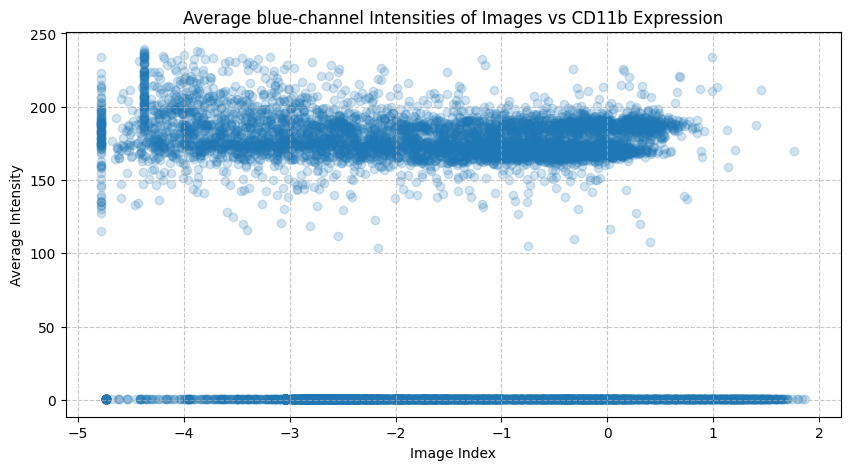

In [14]:
plt.figure(figsize=(10, 5))
plt.scatter(CD11b_values, average_intensities_blue, marker = 'o', alpha = 0.2)
plt.title('Average blue-channel Intensities of Images vs CD11b Expression')
plt.xlabel('Image Index')
plt.ylabel('Average Intensity')
plt.grid(linestyle='--', alpha=0.7)
plt.show()

1.v:

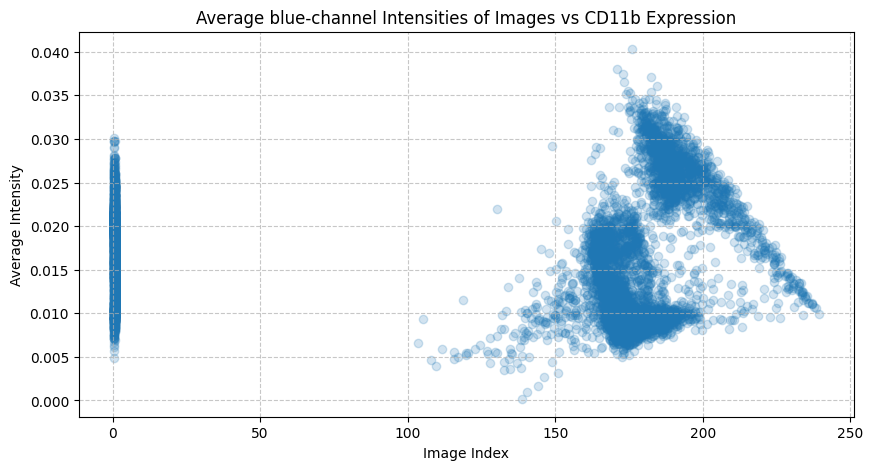

In [15]:
plt.figure(figsize=(10, 5))
plt.scatter(average_intensities_blue, average_intensities_H, marker = 'o', alpha = 0.2)
plt.title('Average blue-channel Intensities of Images vs CD11b Expression')
plt.xlabel('Image Index')
plt.ylabel('Average Intensity')
plt.grid(linestyle='--', alpha=0.7)
plt.show()

$$\text{Question 2:}$$

In [16]:
def HED_split(image):
    if I.shape[-1] == 4:
        I_rgb = rgba2rgb(I)
    else:
        I_rgb = I
    I_hed = rgb2hed(I_rgb)
    
    I_h = I_hed[:, :, 0]
    I_e = I_hed[:, :, 1]
    I_d = I_hed[:, :, 2]
    
    return I_h, I_e, I_d

def RGB_split(image):
    if I.shape[-1] == 4:
        I_rgb = rgba2rgb(I)
    else:
        I_rgb = I
    
    I_r = I_rgb[:, :, 0]
    I_g = I_rgb[:, :, 1]
    I_b = I_rgb[:, :, 2]
    
    return I_r, I_g, I_b

def image_mean_variance(selected, split_function):
    sum_1 = 0
    sum_1_sq = 0
    sum_2 = 0
    sum_2_sq = 0
    sum_3 = 0
    sum_3_sq = 0
    num_pixels = 0
    
    for image in selected:
        image_path = os.path.join(image_folder, image)
        I = imread(image_path)
        I_1, I_2, I_3 = split_function(I)
        
        sum_1 += np.sum(I_1)
        sum_1_sq += np.sum(I_1 ** 2)
        sum_2 += np.sum(I_2)
        sum_2_sq += np.sum(I_2 ** 2)
        sum_3 += np.sum(I_3)
        sum_3_sq += np.sum(I_3 ** 2)
        num_pixels += I_1.size
        
    mean_1 = sum_1 / num_pixels
    variance_1 = (sum_1_sq / num_pixels) - (mean_1 ** 2)

    mean_2 = sum_2 / num_pixels
    E_variance = (sum_2_sq / num_pixels) - (sum_2 ** 2)

    mean_3 = sum_3 / num_pixels
    variance_3 = (sum_3_sq / num_pixels) - (mean_3 ** 2)
    
    return mean_1, variance_1, mean_2, E_variance, mean_3, variance_3

def component_split_flatten(images, split_function):
    components_1 = []
    components_2 = []
    components_3 = []
    
    for image in images:
        image_path = os.path.join(image_folder, image)
        I = imread(image_path)
        I_1, I_2, I_3 = split_function(I)
    
        components_1.append(I_1.flatten())
        components_2.append(I_2.flatten())
        components_3.append(I_3.flatten())

    return np.vstack(components_1), np.vstack(components_2), np.vstack(components_3)

2.i:

$\text{Calculate mean and variance for each sample:}$

In [17]:
image_files = [f for f in filenames_filtered[2895:9921]]
selected_images_B = random.sample(image_files[0:1145], 500)
selected_images_C = random.sample(image_files[1145:5273], 500)
selected_images_D = random.sample(image_files[5274:7026], 500)

H_mean_B, H_variance_B, E_mean_B, E_variance_B, D_mean_B, D_variance_B = image_mean_variance(selected_images_B, HED_split)
H_mean_C, H_variance_C, E_mean_C, E_variance_C, D_mean_C, D_variance_C = image_mean_variance(selected_images_C, HED_split)
H_mean_D, H_variance_D, E_mean_D, E_variance_D, D_mean_D, D_variance_D = image_mean_variance(selected_images_D, HED_split)

blue_mean_B, blue_variance_B, green_mean_B, green_variance_B, red_mean_B, red_variance_B = image_mean_variance(selected_images_B, RGB_split)
blue_mean_C, blue_variance_C, green_mean_C, green_variance_C, red_mean_C, red_variance_C = image_mean_variance(selected_images_C, RGB_split)
blue_mean_D, blue_variance_D, green_mean_D, green_variance_D, red_mean_D, red_variance_D = image_mean_variance(selected_images_D, RGB_split)

print(f"Specimen B:")
print(f"H channel - mean: {H_mean_B}, variance: {H_variance_B}")
print(f"E channel - mean: {E_mean_B}, variance: {E_variance_B}")
print(f"D channel - mean: {D_mean_B}, variance: {D_variance_B}\n")

print(f"Blue Channel - mean: {blue_mean_B}, variance: {blue_variance_B}")
print(f"Green Channel - mean: {green_mean_B}, variance: {green_variance_B}")
print(f"Red Channel - mean: {red_mean_B}, variance: {red_variance_B}\n")

print(f"---------------------------------------------\n")

print(f"Specimen C:")
print(f"H channel - mean: {H_mean_C}, variance: {H_variance_C}")
print(f"E channel - mean: {E_mean_C}, variance: {E_variance_C}")
print(f"D channel - mean: {D_mean_C}, variance: {D_variance_C}\n")

print(f"Blue Channel - mean: {blue_mean_C}, variance: {blue_variance_C}")
print(f"Green Channel - mean: {green_mean_C}, variance: {green_variance_C}")
print(f"Red Channel - Memeanan: {red_mean_C}, variance: {red_variance_C}\n")

print(f"---------------------------------------------\n")

print(f"Specimen D:")
print(f"H channel - mean: {H_mean_D}, variance: {H_variance_D}")
print(f"E channel - mean: {E_mean_D}, variance: {E_variance_D}")
print(f"D channel - mean: {D_mean_D}, variance: {D_variance_D}\n")

print(f"Blue Channel - mean: {blue_mean_D}, variance: {blue_variance_D}")
print(f"Green Channel - mean: {green_mean_D}, variance: {green_variance_D}")
print(f"Red Channel - mean: {red_mean_D}, variance: {red_variance_D}\n")

Specimen B:
H channel - mean: 0.028061122403688066, variance: 0.0008606315841210414
E channel - mean: 0.024956045583766174, variance: -668730929706.2357
D channel - mean: 0.015891903400596156, variance: 0.00012388284251228126

Blue Channel - mean: 189.8725128173828, variance: -35938.006746756146
Green Channel - mean: 139.77764892578125, variance: -2.531799421046448e+18
Red Channel - mean: 189.98802185058594, variance: -35983.83063358837

---------------------------------------------

Specimen C:
H channel - mean: 0.028061122403688066, variance: 0.0008606315841210414
E channel - mean: 0.024956045583766174, variance: -668730929706.2357
D channel - mean: 0.015891903400596156, variance: 0.00012388284251228126

Blue Channel - mean: 189.8725128173828, variance: -35938.006746756146
Green Channel - mean: 139.77764892578125, variance: -2.531799421046448e+18
Red Channel - Memeanan: 189.98802185058594, variance: -35983.83063358837

---------------------------------------------

Specimen D:
H chan

$\text{Isolate a random set of samples from the training set to perform PCA:}$

$\text{(We use a subset for PCA to reduce computation time)}$

In [29]:
import numpy as np
import random
from scipy.stats import skew, kurtosis, entropy
from skimage import exposure
from skimage.io import imread
from skimage.feature import graycomatrix, graycoprops
from skimage.color import separate_stains, hed_from_rgb, rgba2rgb
import os

# Define custom feature extraction functions
def extract_contrast(image):
    return exposure.adjust_sigmoid(image).flatten()

def extract_skewness(image):
    return skew(image.flatten())

def extract_kurtosis(image):
    return kurtosis(image.flatten())

def extract_mean_intensity(image):
    return np.mean(image)

def extract_std_intensity(image):
    return np.std(image)

def extract_entropy(image):
    return entropy(image.flatten())

def extract_energy(image):
    return np.sum(image.flatten() ** 2)

def extract_homogeneity(image):
    image_uint8 = (image * 255).astype(np.uint8)  # Convert to unsigned integer type
    glcm = graycomatrix(image_uint8, [1], [0], 256, symmetric=True, normed=True)
    return graycoprops(glcm, 'homogeneity')[0, 0]

# Define a custom transformer for feature extraction
class ChannelStats:
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        features = []
        for image in X:
            if image.shape[-1] == 4:
                I_rgb = rgba2rgb(image)
            else:
                I_rgb = image

            # Extract RGB components
            # r = I_rgb[:, :, 0]
            # g = I_rgb[:, :, 1]
            # b = I_rgb[:, :, 2]

            # # Separate the image into H, E, and D components
            # hed = separate_stains(I_rgb, hed_from_rgb)
            # h = hed[:, :, 0]
            # e = hed[:, :, 1]
            # d = hed[:, :, 2]

            image_features = []
            # for component in [r, g, b, h, e, d]:
            #     contrast = extract_contrast(component)
            #     skewness = extract_skewness(component)
            #     kurt = extract_kurtosis(component)
            #     mean_intensity = extract_mean_intensity(component)
            #     std_intensity = extract_std_intensity(component)
            #     ent = extract_entropy(component)
            #     energy = extract_energy(component)
            #     homogeneity = extract_homogeneity(component)
            #     contrast_mean = np.mean(contrast)
            #     contrast_std = np.std(contrast)

            #     image_features.extend([
            #         contrast_mean, contrast_std, skewness, kurt,
            #         mean_intensity, std_intensity, ent, energy, homogeneity
            #     ])
            
            for i in I_rgb:
                contrast = extract_contrast(i)
                skewness = extract_skewness(i)
                kurt = extract_kurtosis(i)
                mean_intensity = extract_mean_intensity(i)
                std_intensity = extract_std_intensity(i)
                ent = extract_entropy(i)
                energy = extract_energy(i)
                homogeneity = extract_homogeneity(i)
                contrast_mean = np.mean(contrast)
                contrast_std = np.std(contrast)

                image_features.extend([
                    contrast_mean, contrast_std, skewness, kurt,
                    mean_intensity, std_intensity, ent, energy, homogeneity
                ])
            features.append(image_features)  # One feature vector per image
        return np.array(features)

In [19]:
images_train = image_files[0:500] + image_files[1145:1645] + image_files[5274:5774]

# Load images and extract features
images = [imread(os.path.join(image_folder, img)) for img in images_train]

CD11b_values_train = np.array(CD11b_values[0:500] + CD11b_values[1145:1645] + CD11b_values[5274:5774]).astype(int)

C:\Users\jaisa\AppData\Local\Temp\ipykernel_27660\3544153616.py:6: RuntimeWarning: invalid value encountered in cast
  CD11b_values_train = np.array(CD11b_values[0:500] + CD11b_values[1145:1645] + CD11b_values[5274:5774]).astype(int)


In [30]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# Sets the number of cross-validation folds.
cv_folds=3

# Creates the pipeline for the OLS regression model.
pipeline_ols=Pipeline([
    ("stats",ChannelStats()),  
    ("scaler",StandardScaler()),
    ("pca",PCA()),             
    ("ols",LinearRegression())
])

# Sets the hyperparameters for the OLS regression model to iterate over.
param_grid_ols = {"pca__n_components": [2, 5, 10, 25, 50],}

# Creates the grid search for the OLS regression model.
# Scores are based on the negative mean squared error.
grid_ols=GridSearchCV(
    pipeline_ols,
    param_grid=param_grid_ols,
    cv=cv_folds, 
    scoring="neg_mean_squared_error",
    verbose=2,
    n_jobs=-1
)

# Fit the grid search to the data
grid_ols.fit(images, CD11b_values_train)

# Get the best parameters and best score
best_params = grid_ols.best_params_
best_score = grid_ols.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Score: {best_score}")

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Parameters: {'pca__n_components': 2}
Best Score: 0.0


In [21]:
from sklearn.decomposition import PCA

# Initialize the PCA model
pca = PCA(n_components=54, whiten = True)

# Fit the PCA model to the data
pca.fit(features_array)

# Transform the data
features_pca = pca.transform(features_array)

print("Data transformed using PCA.")




NameError: name 'features_array' is not defined

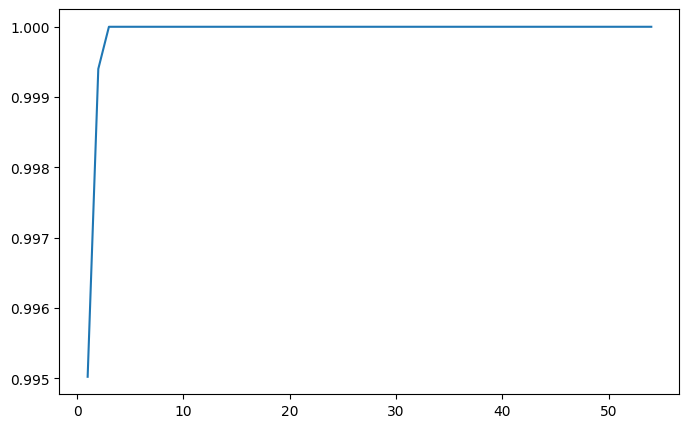

In [ ]:
variance_ratio = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8, 5))

plt.plot(range(1, 55), variance_ratio)

In [ ]:
import numpy as np
import random
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from scipy.stats import skew, kurtosis, entropy
from skimage import exposure
from skimage.io import imread
from skimage.feature import graycomatrix, graycoprops
import os

# Define custom feature extraction functions
def extract_contrast(image):
    return exposure.adjust_sigmoid(image).flatten()

def extract_skewness(image):
    return skew(image.flatten())

def extract_kurtosis(image):
    return kurtosis(image.flatten())

def extract_mean_intensity(image):
    return np.mean(image)

def extract_std_intensity(image):
    return np.std(image)

def extract_entropy(image):
    return entropy(image.flatten())

def extract_energy(image):
    return np.sum(image.flatten() ** 2)

def extract_homogeneity(image):
    image_uint8 = (image * 255).astype(np.uint8)  # Convert to unsigned integer type
    glcm = graycomatrix(image_uint8, [1], [0], 256, symmetric=True, normed=True)
    return graycoprops(glcm, 'homogeneity')[0, 0]

def extract_crest_factor(image):
    return np.max(image) / np.mean(image)

# Define a custom transformer for feature extraction
class ChannelStats:
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        features = []
        for image in X:
            if image.shape[-1] == 4:
                I_rgb = rgba2rgb(image)
            else:
                I_rgb = image

            hed = separate_stains(I_rgb, hed_from_rgb)
            h = hed[:, :, 0]
            e = hed[:, :, 1]
            d = hed[:, :, 2]

            image_features = []
            for component in [h, e, d]:
                contrast = extract_contrast(component)
                skewness = extract_skewness(component)
                kurt = extract_kurtosis(component)
                mean_intensity = extract_mean_intensity(component)
                std_intensity = extract_std_intensity(component)
                ent = extract_entropy(component)
                energy = extract_energy(component)
                homogeneity = extract_homogeneity(component)
                contrast_mean = np.mean(contrast)
                contrast_std = np.std(contrast)

                image_features.extend([
                    contrast_mean, contrast_std, skewness, kurt,
                    mean_intensity, std_intensity, ent, energy, homogeneity
                ])
            features.append(image_features)  # One feature vector per image
        return np.array(features)

# Sample a subset of images for PCA
PCA_images = random.sample(image_files, 1000)

# Load images and extract features
images = [imread(os.path.join(image_folder, img)) for img in PCA_images]

# Sets the number of cross-validation folds
cv_folds = 3

# Creates the pipeline for the OLS regression model
pipeline_ols = Pipeline([
    ("stats", ChannelStats()),  
    ("scaler", StandardScaler()),
    ("pca", PCA()),             
    ("ols", LinearRegression())
])

# Sets the hyperparameters for the OLS regression model to iterate over
param_grid_ols = {"pca__n_components": [2, 4, 6, 8],}

# Creates the grid search for the OLS regression model
# Scores are based on the negative mean squared error
grid_ols = GridSearchCV(
    pipeline_ols,
    param_grid=param_grid_ols,
    cv=cv_folds, 
    scoring="neg_mean_squared_error",
    verbose=2
)

# Fit the grid search to the data
grid_ols.fit(images, CD11b_values[:1000])  # Assuming CD11b_values contains the corresponding labels

# Get the best parameters and best score
best_params = grid_ols.best_params_
best_score = grid_ols.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Score: {best_score}")

# Extract features using the best estimator
best_estimator = grid_ols.best_estimator_
features = best_estimator.named_steps['stats'].transform(images)

# Append features to an array
features_array = np.array(features)

print("Features extracted and appended to array.")

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END ................................pca__n_components=2; total time=  21.4s
[CV] END ................................pca__n_components=2; total time=  20.5s
[CV] END ................................pca__n_components=2; total time=  19.8s
[CV] END ................................pca__n_components=4; total time=  19.5s
[CV] END ................................pca__n_components=4; total time=  26.9s
[CV] END ................................pca__n_components=4; total time=  22.7s


Exception ignored in: <function PluginV3.__del__ at 0x0000028F64509260>
Traceback (most recent call last):
  File "C:\Users\jaisa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\imageio\core\v3_plugin_api.py", line 370, in __del__
    self.close()
  File "C:\Users\jaisa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\imageio\plugins\pillow.py", line 144, in close
    self._flush_writer()
  File "C:\Users\jaisa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\imageio\plugins\pillow.py", line 476, in _flush_writer
    if len(self.images_to_write) == 0:
           ^^^^^^^^^^^^^^^^^^^^
AttributeError: 'PillowPlugin' object has no attribute 'images_to_write'


[CV] END ................................pca__n_components=6; total time=  26.4s
[CV] END ................................pca__n_components=6; total time=  20.4s
[CV] END ................................pca__n_components=6; total time=  20.9s
[CV] END ................................pca__n_components=8; total time=  21.2s
[CV] END ................................pca__n_components=8; total time=  20.0s
[CV] END ................................pca__n_components=8; total time=  23.4s
Best Parameters: {'pca__n_components': 2}
Best Score: -0.7798412267348036
Features extracted and appended to array.


$$\text{Question 3:}$$

3.i:

In [ ]:
images_train = image_files[0:500] + image_files[1145:1645] + image_files[5274:5774]

# Load images and extract features
images = [imread(os.path.join(image_folder, img)) for img in images_train]

CD11b_values_train = np.array(CD11b_values[0:500] + CD11b_values[1145:1645] + CD11b_values[5274:5774]).astype(int)

C:\Users\jaisa\AppData\Local\Temp\ipykernel_2432\3544153616.py:6: RuntimeWarning: invalid value encountered in cast
  CD11b_values_train = np.array(CD11b_values[0:500] + CD11b_values[1145:1645] + CD11b_values[5274:5774]).astype(int)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr, spearmanr
import numpy as np
import matplotlib.pyplot as plt
import os
import random


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# I used the standard ResNet-18 transformations for the training and validation sets
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

resnet50 = models.resnet50(pretrained=True)
resnet50 = nn.Sequential(*list(resnet50.children())[:-1])
resnet50.eval()
resnet50.to(device)

class CustomImageDataset(Dataset):
    def __init__(self, image_folder, image_files, CD11b_values, transform=None):
        self.image_folder = image_folder
        self.image_files = image_files
        self.cd11b_values = CD11b_values
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_folder, self.image_files[idx])
        image = Image.open(img_path).convert("RGB")
        label = self.cd11b_values[idx]
        if self.transform:
            image = self.transform(image)
        return image, label



    
# CD11b_values_train is the first 500 CD11b values from specimen B, the first 500 CD11b values from specimen C, and the first 500 CD11b values from specimen D
CD11b_values_test = CD11b_values[0:2894]
    
# I used a subset of 1500 images for training to aid computation
# images_train is the first 500 images from specimen B, the first 500 images from specimen C, and the first 500 images from specimen D
test_image_files = image_files[0:2894]

train_dataset = CustomImageDataset(image_folder = image_folder, image_files = images_train, CD11b_values = CD11b_values_train, transform = transform)
test_dataset = CustomImageDataset(image_folder = image_folder, image_files = test_image_files, CD11b_values = CD11b_values_test, transform = transform)

train_loader = DataLoader(train_dataset, batch_size = 8, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 8, shuffle = False)


# next we define the neural network 
class CD11bPredictor(nn.Module):
    def __init__(self, input_dim):
        super(CD11bPredictor, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# next we initialize the model
#model = CD11bPredictor(input_dim = 2048)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, resnet50.parameters()), lr=0.0001)
criterion = nn.MSELoss()


# I used a larger number of epochs to train the model to reduce loss with a learning rate of 0.001
num_epochs = 10
resnet50.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
        optimizer.zero_grad()
        outputs = resnet50(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}')


resnet50.eval()
true_values = []
predicted_values = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet50(inputs)
        true_values.extend(labels.cpu().numpy())
        predicted_values.extend(outputs.cpu().numpy())

# next we calculate performance metrics
rmse = np.sqrt(mean_squared_error(true_values, predicted_values))
pearson_correlation_coefficient, _ = pearsonr(true_values, predicted_values)
spearman_correlation_coefficient, _ = spearmanr(true_values, predicted_values)
r2 = r2_score(true_values, predicted_values)

print(f'RMSE: {rmse}')
print(f'Pearson Correlation Coefficient: {pearson_correlation_coefficient}')
print(f'Spearman Correlation Coefficient: {spearman_correlation_coefficient}')
print(f'R2 Score: {r2}')

# Finally we make a scatter plot of true vs. predicted values
plt.scatter(true_values, predicted_values)
plt.xlabel('True CD11b Expression')
plt.ylabel('Predicted CD11b Expression')
plt.title('True vs. Predicted CD11b Expression')
plt.show()

KeyboardInterrupt: 